Starting Real-Scale River Avon Flood Model...
This simulates a 24*7-hour period with UK frontal rainfall patterns
Real-Scale Flood Model - River Avon, Bath UK
River Length: 15 km through Bath area
Canal System: Kennet and Avon Canal
Rainfall: UK frontal system patterns
Simulation: 24*7-hour period
Simulation completed in 2.68 seconds
Total time steps: 12801


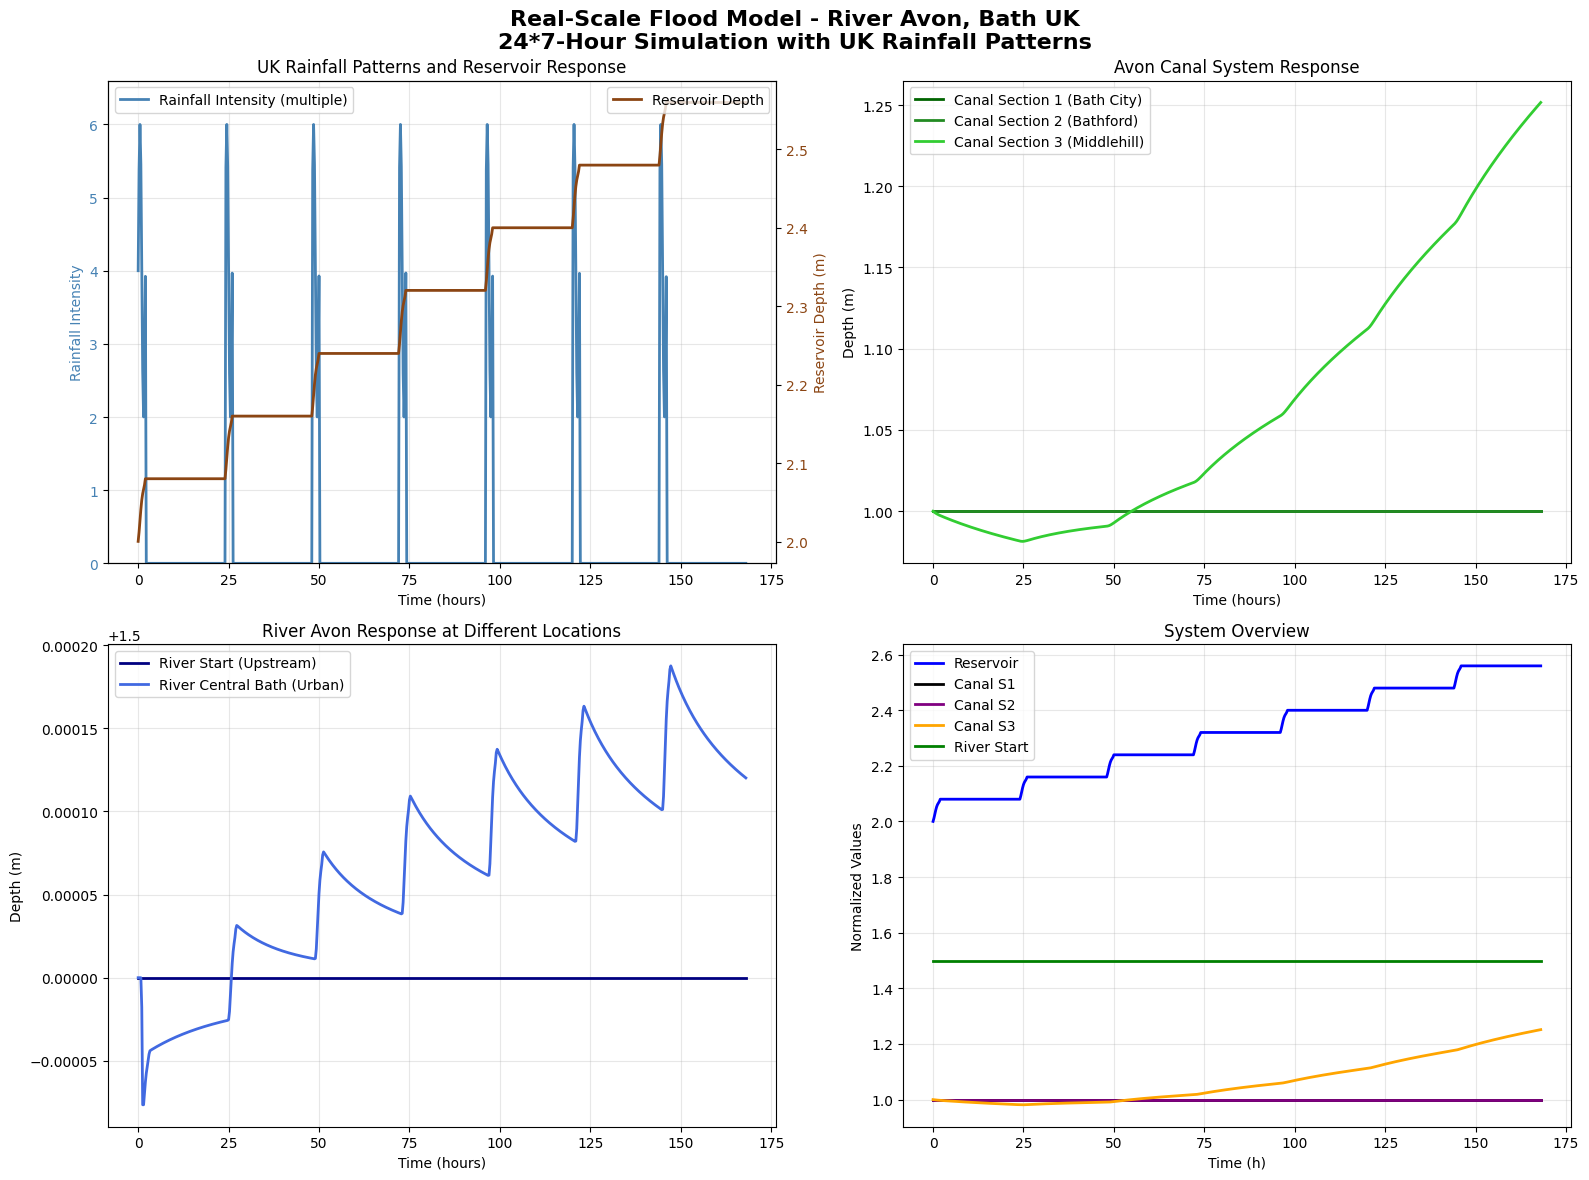


=== REAL-SCALE MODEL SUMMARY ===
Maximum reservoir depth: 2.559376 m
Maximum canal depth (Section 1): 1.000000 m
Maximum canal depth (Section 2): 1.000000 m
Maximum canal depth (Section 3): 1.251557 m
Maximum river depth in Central Bath: 1.500187 m
Maximum river depth in Avon: 1.500121 m, minimum: 1.500000 m


In [ ]:
# -*- coding: utf-8 -*-
"""
Real-Scale Flood Model - River Avon, Bath UK Version

Scaled up from tabletop to real geographical dimensions

Based on River Avon in Bath, UK characteristics:
- River length: ~15km in Bath area
- Canal system: Kennet and Avon Canal  
- Typical rainfall: UK climate patterns
"""

import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import time

class RealScaleFloodModelConfig:
    """Configuration for real-scale River Avon, Bath model"""
    
    def __init__(self):
        # Physical constants
        self.gravity = 9.81  # m/s²
        
        # === RIVER AVON CHARACTERISTICS ===
        self.river_length = 15000  # meters ~15km through Bath area
        self.river_width = 30.0    # meters - typical width in Bath
        self.river_bed_slope = 0.001  # 0.1% slope - typical for Avon
        
        # === AVON CANAL SYSTEM ===
        self.canal_width = 3.0  # meters - typical canal width
        self.canal_max_depth = 2.0  # meters
        
        # Lock positions (approximate distances along river)
        self.lock3_position = 3000   # m - Middlehill
        self.lock2_position = 6000   # m - Bathford
        self.lock1_position = 12000  # m - Bath city
        
        # Canal section lengths0d 
        self.section3_length = self.lock3_position
        self.section2_length = self.lock2_position - self.lock3_position
        self.section1_length = self.lock1_position - self.lock2_position
        
        # Lock characteristics
        self.lock3_overflow_depth = 1.5   # meters
        self.lock2_overflow_depth = 1.5   # meters  
        self.lock1_overflow_depth = 1.2   # meters
        
        # === Moor AREAS===
        self.moor_length = 1000     # meters - typical wetland size
        self.moor_width = 500       # meters - wetland width
        self.moor_inflow_position = 5000  # meters along river
        
        # moor material properties
        self.moor_porosity = 0.35
        self.moor_pore_fill_ratio = 0.7
        self.moor_permeability = 1e-10  # m² - real soil permeability # double check parameters
        
        # === RESERVOIR CHARACTERISTICS ===
        self.reservoir_position = 8000    # meters
        self.reservoir_width = 200        # meters
        self.reservoir_length = 500       # meters
        self.reservoir_weir_height = 3.0  # meters
        
        # === UK RAINFALL CHARACTERISTICS ===
        self.rain_intensity_base = (1 * 10e-3) / (60 * 60)  # m/s = 1 mm/h (10 mm/hour = heavy rain)
        
        # === INITIAL CONDITIONS ===
        self.initial_river_depth = 1.5    # meters - normal river depth
        self.initial_canal_depth = 1.0    # meters - normal canal depth
        self.initial_reservoir_depth = 2.0  # meters - normal reservoir depth
        
        # === NUMERICAL PARAMETERS ===
        self.river_cells = 100
        self.moor_cells = 50
        
        # Flow coefficients
        self.flow_coefficient = (2/3)**(3/2)  # Standard weir coefficient
        self.manning_coefficient = 0.035  # For natural rivers
        
        # Flow distribution (Moor)
        self.flow_split_to_canal = 0.5  # 50% to canal, 50% to river (? not sure about this)
        
        # === TIME PARAMETERS ===
        self.time_unit = 3600  # 1 hour in seconds
        self.total_simulation_time = 24 * 3600 * 7  # 24*7 hours simulation


class RealScaleSpatialGrid:
    """Spatial discretization for real-scale model"""
    
    def __init__(self, config):
        self.config = config
        
        # River grid
        self.river_cell_size = config.river_length / config.river_cells
        self.river_nodes = np.linspace(0, config.river_length, config.river_cells + 1)
        self.river_cell_centers = 0.5 * (self.river_nodes[1:] + self.river_nodes[:-1])
        self.river_cell_lengths = np.diff(self.river_nodes)
        
        # moor grid
        self.moor_cell_size = config.moor_length / config.moor_cells
        self.moor_nodes = np.linspace(0, config.moor_length, config.moor_cells + 1)
        
        # Key position indices
        self.moor_inflow_index = self._find_cell_index(config.moor_inflow_position)
        self.lock1_index = self._find_cell_index(config.lock1_position)
        self.reservoir_index = self._find_cell_index(config.reservoir_position)
        
        # Topography - River Avon valley profile
        self.river_bed_elevation = self._calculate_river_bed()
        self.embankment_profile = self._calculate_embankments()
    
    def _find_cell_index(self, position):
        """Find cell index for a given position"""
        return min(int(np.ceil(position / self.river_cell_size)), self.config.river_cells - 1)
    
    def _calculate_river_bed(self):
        """Calculate river bed elevation for Avon valley"""
        # Avon valley slopes gently downward
        valley_slope = self.config.river_bed_slope
        return (self.config.river_length - self.river_cell_centers) * valley_slope
    
    def _calculate_embankments(self):
        """Calculate embankment/flood defense heights"""
        heights = np.ones_like(self.river_cell_centers) * 3.0  # Base flood defense height
        
        # Higher defenses in urban Bath area
        urban_area = (self.river_cell_centers > 5000) & (self.river_cell_centers < 10000)
        heights[urban_area] = 4.0  # Enhanced urban flood defenses
        
        return heights


class RealScalePhysicsCalculator:
    """Physical calculations for real-scale model"""
    
    def __init__(self, config):
        self.config = config
        self.water_viscosity = 1e-6  # m²/s
        self.moor_alpha = self._calculate_moor_alpha()
    
    def _calculate_moor_alpha(self):
        """Calculate moor flow coefficient for real soils"""
        return (self.config.moor_permeability / 
                (self.config.moor_porosity * self.water_viscosity * 
                 self.config.moor_pore_fill_ratio))
    
    def calculate_weir_flow(self, upstream_depth, overflow_depth, width):
        """Calculate flow over a weir"""
        head = max(upstream_depth - overflow_depth, 0)
        return (width * np.sqrt(self.config.gravity) * 
                self.config.flow_coefficient * head**1.5)
    
    def calculate_river_velocity(self, river_depth):
        """Calculate river velocity using Manning's equation"""
        hydraulic_radius = (self.config.river_width * river_depth / 
                          (2 * river_depth + self.config.river_width))
        return (hydraulic_radius**(2/3) * np.sqrt(self.config.river_bed_slope) / 
                self.config.manning_coefficient)
    
    def calculate_moor_flow(self, depth_upstream, depth_downstream):
        """Calculate flow in moor"""
        return (self.moor_alpha * self.config.gravity * 0.5 * 
                (depth_upstream**2 - depth_downstream**2))
    
    def calculate_time_step(self, river_velocities, moor_depths):
        """Calculate stable time step for real-scale model"""
        # River CFL condition
        max_river_velocity = np.max(np.abs(river_velocities))
        river_dt = (self.config.river_length / self.config.river_cells / 
                   max_river_velocity if max_river_velocity > 0 else 60.0)  # 1 min default
        
        # moor diffusion condition
        max_moor_depth = max(np.max(moor_depths), 0.1)  # Increased minimum
        moor_dt = (self.config.moor_length / self.config.moor_cells)**2 / \
                  (self.moor_alpha * self.config.gravity * max_moor_depth)
        
        # Use minimum with safety factor - but limit maximum dt 
        return min(0.35 * min(river_dt, moor_dt), 300.0)  # Max 5 minutes


class UKRainfallForcing:
    """UK-style rainfall patterns based on Bath climate"""
    
    def __init__(self, config):
        self.config = config
        
        # UK rainfall patterns (assumptions)
        # self.period = 6 * 3600  # 6-hour cycles 
        # self.period = 24 * 3600 * 3 # 3-day cycles
        self.period = 24 * 3600 # 1-day cycles
        self.rain_duration = 2 * 3600  # 2-hour rainfall 
        self.amplitude = 5.0  # Intensity multiplier 
    
    def uk_rainfall_pattern(self, current_time):
        """UK-style rainfall with frontal systems"""
        phase = current_time % self.period
        
        if phase < self.rain_duration:
            # Rainfall period - simulate frontal rain 
            intensity = self.amplitude
            # Add some variability 
            intensity *= (0.8 + 0.4 * np.sin(2 * np.pi * phase / self.rain_duration))
        else:
            # Dry period 
            intensity = 0.0
            
        return intensity
    
    def get_rainfall_pattern(self, current_time):
        """Get rainfall pattern for UK conditions"""
        rain_intensity = self.uk_rainfall_pattern(current_time)
        
        # Apply to both moor and reservoir
        moor_rainfall = np.full(self.config.moor_cells + 1, 
                               rain_intensity * self.config.rain_intensity_base * 0.8)
        reservoir_rainfall = np.full(self.config.moor_cells + 1, 
                                   rain_intensity * self.config.rain_intensity_base)
        
        return moor_rainfall, reservoir_rainfall, rain_intensity


class RealScaleSystemState:
    """System state for real-scale model"""
    
    def __init__(self, config, grid):
        self.config = config
        self.grid = grid
        
        # Time tracking
        self.current_time = 0.0
        self.time_step_count = 0
        
        # Canal system
        self.canal_depths = np.full(3, config.initial_canal_depth)
        
        # moor system
        self.moor_depths = np.full(config.moor_cells + 1, 0.5)  # Initial moor water
        
        # River system
        self.river_cross_sections = (config.initial_river_depth * 
                                   config.river_width * np.ones(config.river_cells))
        self.river_velocities = np.zeros(config.river_cells)
        
        # Reservoir
        self.reservoir_depth = config.initial_reservoir_depth
        
        # Rainfall
        self.moor_rainfall = np.zeros(config.moor_cells + 1)
        self.reservoir_rainfall = np.zeros(config.moor_cells + 1)
        
        # Forcing pattern
        self.forcing = UKRainfallForcing(config)
        self.current_rain_intensity = 0.0
        
        # Recording
        self.recording_interval = 60 * 15  # 15 minutes
        self.next_record_time = 0.0
        
    @property
    def river_depths(self):
        """Calculate river depths from cross-sectional areas"""
        return self.river_cross_sections / self.config.river_width


class RealScaleModelUpdater:
    """Update real-scale model state"""
    
    def __init__(self, config, grid, physics):
        self.config = config
        self.grid = grid
        self.physics = physics
    
    def update_canal_system(self, state, dt):
        """Update canal system state"""
        old_depths = state.canal_depths.copy()
        
        # Calculate flows between sections
        flow_lock3 = self.physics.calculate_weir_flow(
            old_depths[2], self.config.lock3_overflow_depth, self.config.canal_width)
        flow_lock2 = self.physics.calculate_weir_flow(
            old_depths[1], self.config.lock2_overflow_depth, self.config.canal_width)
        flow_lock1 = self.physics.calculate_weir_flow(
            old_depths[0], self.config.lock1_overflow_depth, self.config.canal_width)
        
        # Flow from moor to canal section 3
        moor_to_canal_flow = (self.config.flow_split_to_canal * 
                              self.config.moor_porosity * self.config.moor_pore_fill_ratio * 
                              self.config.moor_width * self.physics.calculate_moor_flow(
                                  state.moor_depths[1], old_depths[2]) / 
                              (self.config.moor_length / self.config.moor_cells))
        
        # Update canal depths
        state.canal_depths[2] = old_depths[2] + (dt / 
            (self.config.section3_length * self.config.canal_width)) * (
            moor_to_canal_flow - flow_lock3)
        
        state.canal_depths[1] = old_depths[1] + (dt / 
            (self.config.section2_length * self.config.canal_width)) * (
            flow_lock3 - flow_lock2)
        
        state.canal_depths[0] = old_depths[0] + (dt / 
            (self.config.section1_length * self.config.canal_width)) * (
            flow_lock2 - flow_lock1)
        
        state.canal_depths = np.maximum(state.canal_depths, 0)
        
        return flow_lock1
    
    def update_moor_system(self, state, dt):
        """Update moor system state"""
        old_depths = state.moor_depths.copy()
        diffusion_coeff = dt / (self.config.moor_length / self.config.moor_cells)**2
        
        # Boundary condition
        state.moor_depths[0] = state.canal_depths[2]
        
        # Interior points
        for i in range(1, self.config.moor_cells):
            flow_up = 0.5 * (old_depths[i+1] + old_depths[i]) * (old_depths[i+1] - old_depths[i])
            flow_down = 0.5 * (old_depths[i] + old_depths[i-1]) * (old_depths[i] - old_depths[i-1])
            
            state.moor_depths[i] = (old_depths[i] + diffusion_coeff * 
                                   self.physics.moor_alpha * self.config.gravity * 
                                   (flow_up - flow_down) + dt * state.moor_rainfall[i] / 
                                   (self.config.moor_porosity * self.config.moor_pore_fill_ratio))
        
        # Boundary
        i = self.config.moor_cells
        flow_boundary = (old_depths[i-1] + old_depths[i]) * (old_depths[i-1] - old_depths[i])
        state.moor_depths[i] = (old_depths[i] + diffusion_coeff * 
                               self.physics.moor_alpha * self.config.gravity * 
                               flow_boundary + dt * state.moor_rainfall[i] / 
                               (self.config.moor_porosity * self.config.moor_pore_fill_ratio))
        
        state.moor_depths = np.maximum(state.moor_depths, 0)
    
    def update_reservoir(self, state, dt):
        """Update reservoir state"""
        reservoir_outflow = self.physics.calculate_weir_flow(
            state.reservoir_depth, self.config.reservoir_weir_height, self.config.reservoir_width)
        
        state.reservoir_depth += (dt * state.reservoir_rainfall[0] - 
                                (dt / (self.config.reservoir_length * self.config.reservoir_width)) * 
                                reservoir_outflow)
        
        state.reservoir_depth = max(state.reservoir_depth, 0)
        
        return reservoir_outflow
    
    def update_river_system(self, state, dt, canal_outflow, reservoir_outflow):
        """Update river system state"""
        old_sections = state.river_cross_sections.copy()
        
        # Calculate flows
        flows = np.zeros(self.config.river_cells + 1)
        
        # Upstream boundary
        upstream_velocity = self.physics.calculate_river_velocity(self.config.initial_river_depth)
        flows[0] = self.config.initial_river_depth * self.config.river_width * upstream_velocity
        
        # Interior flows
        for i in range(1, self.config.river_cells + 1):
            depth = old_sections[i-1] / self.config.river_width
            velocity = self.physics.calculate_river_velocity(depth)
            flows[i] = old_sections[i-1] * velocity
        
        # Update cross-sections
        for i in range(self.config.river_cells):
            state.river_cross_sections[i] = (old_sections[i] - 
                                           dt * (flows[i+1] - flows[i]) / self.grid.river_cell_lengths[i])
            
            # Add source terms
            if i == self.grid.moor_inflow_index:
                moor_to_river_flow = ((1 - self.config.flow_split_to_canal) * 
                                     self.config.moor_porosity * self.config.moor_pore_fill_ratio * 
                                     self.config.moor_width * self.physics.calculate_moor_flow(
                                         state.moor_depths[1], state.canal_depths[2]) / 
                                     (self.config.moor_length / self.config.moor_cells))
                state.river_cross_sections[i] += (dt * moor_to_river_flow / 
                                                self.grid.river_cell_lengths[i])
            
            if i == self.grid.reservoir_index:
                state.river_cross_sections[i] += (dt * reservoir_outflow / 
                                                self.grid.river_cell_lengths[i])
            
            if i == self.grid.lock1_index:
                state.river_cross_sections[i] += (dt * canal_outflow / 
                                                self.grid.river_cell_lengths[i])
        
        state.river_cross_sections = np.maximum(state.river_cross_sections, 0)
        state.river_velocities = self.physics.calculate_river_velocity(state.river_depths)


def run_real_scale_experiment():
    """Run real-scale River Avon experiment"""
    
    print("Real-Scale Flood Model - River Avon, Bath UK")
    print("=" * 60)
    print("River Length: 15 km through Bath area")
    print("Canal System: Kennet and Avon Canal")
    print("Rainfall: UK frontal system patterns")
    print("Simulation: 24*7-hour period")
    print("=" * 60)
    
    # Initialize components
    config = RealScaleFloodModelConfig()
    grid = RealScaleSpatialGrid(config)
    physics = RealScalePhysicsCalculator(config)
    updater = RealScaleModelUpdater(config, grid, physics)
    state = RealScaleSystemState(config, grid)
    
    # Recording
    time_history = []
    rain_history = []
    reservoir_history = []
    canal1_history = []
    canal2_history = []
    canal3_history = []
    river_start_history = []
    river_urban_history = []
    # river_along_history = []
    
    urban_index = grid._find_cell_index(12000)  # Central Bath
    # along_river_index = grid.river_nodes
    
    # Main simulation loop
    start_time = time.time()
    
    while state.current_time <= config.total_simulation_time:
        # Update rainfall
        (state.moor_rainfall, state.reservoir_rainfall, 
         state.current_rain_intensity) = state.forcing.get_rainfall_pattern(state.current_time)
        
        # Calculate time step
        dt = physics.calculate_time_step(state.river_velocities, state.moor_depths)
        state.current_time += dt
        state.time_step_count += 1
        
        # Update system
        canal_outflow = updater.update_canal_system(state, dt)
        updater.update_moor_system(state, dt)
        reservoir_outflow = updater.update_reservoir(state, dt)
        updater.update_river_system(state, dt, canal_outflow, reservoir_outflow)
        
        # Record data
        if state.current_time >= state.next_record_time:
            state.next_record_time += state.recording_interval
            
            time_history.append(state.current_time / 3600)  # Convert to hours
            rain_history.append(state.current_rain_intensity)
            reservoir_history.append(state.reservoir_depth)
            canal1_history.append(state.canal_depths[0])
            canal2_history.append(state.canal_depths[1])
            canal3_history.append(state.canal_depths[2])
            river_start_history.append(state.river_depths[0])
            river_urban_history.append(state.river_depths[urban_index])
            # for ri in along_river_index:
            #     river_along_history.append(state.river_depths[int(ri)])
    
    # Simulation completed
    end_time = time.time()
    print(f"Simulation completed in {end_time - start_time:.2f} seconds")
    print(f"Total time steps: {state.time_step_count}")
    
    return (time_history, rain_history, reservoir_history, 
            canal1_history, canal2_history, canal3_history, 
            river_start_history, river_urban_history, state.river_depths)


def plot_real_scale_results(results):
    """Plot results for real-scale model"""
    
    time_hist, rain, reservoir, canal1, canal2, canal3, river_start, river_urban, river_along = results
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Real-Scale Flood Model - River Avon, Bath UK\n24*7-Hour Simulation with UK Rainfall Patterns', 
                 fontsize=16, fontweight='bold')
    
    # Plot 1: UK Rainfall and Reservoir
    ax1 = axes[0, 0]
    ax1.plot(time_hist, rain, 'steelblue', linewidth=2, label='Rainfall Intensity (multiple)')
    ax1.set_ylabel('Rainfall Intensity', color='steelblue')
    ax1.tick_params(axis='y', labelcolor='steelblue')
    ax1.set_ylim(0, max(rain)*1.1)
    ax1.legend(loc='upper left')
    
    ax1_twin = ax1.twinx()
    ax1_twin.plot(time_hist, reservoir, 'saddlebrown', linewidth=2, label='Reservoir Depth')
    ax1_twin.set_ylabel('Reservoir Depth (m)', color='saddlebrown')
    ax1_twin.tick_params(axis='y', labelcolor='saddlebrown')
    ax1_twin.legend(loc='upper right')
    ax1.set_xlabel('Time (hours)')
    ax1.set_title('UK Rainfall Patterns and Reservoir Response')
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Avon Canal System
    axes[0, 1].plot(time_hist, canal1, 'darkgreen', linewidth=2, label='Canal Section 1 (Bath City)')
    axes[0, 1].plot(time_hist, canal2, 'forestgreen', linewidth=2, label='Canal Section 2 (Bathford)')
    axes[0, 1].plot(time_hist, canal3, 'limegreen', linewidth=2, label='Canal Section 3 (Middlehill)')
    axes[0, 1].set_xlabel('Time (hours)')
    axes[0, 1].set_ylabel('Depth (m)')
    axes[0, 1].set_title('Avon Canal System Response')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Plot 3: River Avon Response
    axes[1, 0].plot(time_hist, river_start, 'navy', linewidth=2, label='River Start (Upstream)')
    axes[1, 0].plot(time_hist, river_urban, 'royalblue', linewidth=2, label='River Central Bath (Urban)')
    axes[1, 0].set_xlabel('Time (hours)')
    axes[1, 0].set_ylabel('Depth (m)')
    axes[1, 0].set_title('River Avon Response at Different Locations')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    

    # Plot 4: System overview
    # axes[1, 1].plot(time_hist, rain, 'red', linewidth=1, label='Rainfall', alpha=0.7)
    axes[1, 1].plot(time_hist, reservoir, 'blue', linewidth=2, label='Reservoir')
    axes[1, 1].plot(time_hist, canal1, 'black', linewidth=2, label='Canal S1')
    axes[1, 1].plot(time_hist, canal2, 'purple', linewidth=2, label='Canal S2')
    axes[1, 1].plot(time_hist, canal3, 'orange', linewidth=2, label='Canal S3')
    axes[1, 1].plot(time_hist, river_start, 'green', linewidth=2, label='River Start')
    # axes[1, 1].plot(time_hist, river_along, 'y-', linewidth=2, label='River Along')
    axes[1, 1].set_xlabel('Time (h)')
    axes[1, 1].set_ylabel('Normalized Values')
    axes[1, 1].set_title('System Overview')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"\n=== REAL-SCALE MODEL SUMMARY ===")
    print(f"Maximum reservoir depth: {max(reservoir):.6f} m")
    print(f"Maximum canal depth (Section 1): {max(canal1):.6f} m")
    print(f"Maximum canal depth (Section 2): {max(canal2):.6f} m")
    print(f"Maximum canal depth (Section 3): {max(canal3):.6f} m")
    print(f"Maximum river depth in Central Bath: {max(river_urban):.6f} m")
    print(f"Maximum river depth in Avon: {max(river_along):.6f} m, minimum: {min(river_along):.6f} m")
    # print(f"Flood warning level breaches: {sum(flood_risk)}")
    
    # if any(flood_risk):
    #     flood_duration = sum(flood_risk) * (time_hist[1] - time_hist[0])  # hours
    #     print(f"Total flood risk duration: {flood_duration:.1f} hours")
    #     print(f"Peak flood depth: {max(flood_depths):.2f} m")
    
    return fig


# Main execution
if __name__ == "__main__":
    print("Starting Real-Scale River Avon Flood Model...")
    print("This simulates a 24*7-hour period with UK frontal rainfall patterns")
    
    results = run_real_scale_experiment()
    plot_real_scale_results(results)